# 프로젝트: Movielens 영화 추천 실습
* 🎬협업 필터링(Collaborative Filtering): 콘텐츠 자체의 특성들에 대해 분석한다.
* 🎬활용 데이터: Movielens
    * 관련 링크: https://www.tensorflow.org/datasets/catalog/movielens
     
* 🎬루브릭
    * CSR matrix가 정상적으로 만들어졌다.
        * 사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다.
    * MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다.
        * 사용자와 아이템 벡터 내적수치가 의미있게 형성되었다.
    * 비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다.
        * MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도가 의미있게 측정되었다.
---

## 데이터 준비 
🎬사용 라이브러리를 import하고 사용 디렉토리의 경로를 설정합니다. 
### 사용 라이브러리

In [1]:
import os
import wget # file download 
import pandas as pd 
import numpy as np

from scipy.sparse import csr_matrix # csr matrix 
from implicit.als import AlternatingLeastSquares


### 사용 디렉토리 설정

In [2]:
# import os # 위에서 이미 import 했습니다. 

project_path = os.getenv("HOME")+'/aiffel/recommendata_iu'

if not os.path.isdir(project_path):
    os.mkdir(project_path)

else:
    print("project_path에 폴더가 이미 존재합니다.")

project_path에 폴더가 이미 존재합니다.


In [3]:
data_path = os.getenv('HOME') + '/aiffel/recommendata_iu/data'

if not os.path.isdir(data_path):
    os.mkdir(data_path)

else:
    print("data_path에 폴더가 이미 존재합니다.")

data_path에 폴더가 이미 존재합니다.


🎬유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있습니다. MovieLens 1M Dataset 사용을 권장합니다.

In [4]:
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
file_path = data_path + '/ml-lm.zip'

if not os.path.isfile(file_path):
    wget.download(url, out = file_path)
    os.system('unzip ml-lm.zip') # zip 압축 풀기 

else:
    print("ml-lm.zip가 이미 존재합니다.")
    
rating_file_path= data_path + '/ml-1m/ratings.dat' # 평점 메타데이터 
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat' # 영화제목 메타데이터
print(f'평점 메타데이터 파일 경로: {rating_file_path}')
print(f'영화 메타데이터 파일 경로: {movie_file_path}')

ml-lm.zip가 이미 존재합니다.
평점 메타데이터 파일 경로: /home/aiffel-dj19/aiffel/recommendata_iu/data/ml-1m/ratings.dat
영화 메타데이터 파일 경로: /home/aiffel-dj19/aiffel/recommendata_iu/data/ml-1m/movies.dat


## 데이터 전처리 및 분석
🎬암묵적 데이터인 ratings 해석

* 별점 데이터는 대표적인 explicit 데이터입니다. 하지만 implicit 데이터로 간주하고 테스트해볼 수 있습니다.
* 별점을 시청횟수로 해석해서 생각하겠습니다.
* 또한 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외하겠습니다.
* 메타데이터의 각 항목에 대한 이해 
    * user_id: 평가에 참여한 사용자 고유 식별자 
    * movie_id: 영화 고유 식별자
    * rating: 별점 등급(rating은 사전적 의미로 시청률을 의미하기도 함, 시청횟수로 해석)
    * timestamp: 1970년 1월 1일 자정 UTC(협정 세계시)이후 초 단위로 표시되는 등급의 타임 스탬프

🎬csv계열 파일의 seperator(delimeter, 구분자)란? <br>
컬럼이 어떤 값을 기준으로 구분되고 있는지를 의미합니다. 따라서 엑셀과 같은 응용프로그램으로 구분자가 무엇인지 아래와 같이 확인 후 seperator를 지정해줄 수 있습니다. 
```
# ratings.dat 파일 내용
1::1193::5::978300760
1::661::3::978302109
1::914::3::978301968
1::3408::4::978300275
...
```

In [5]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python') # ::로 구분되는 파일 읽기 
orginal_data_size = len(ratings) 
ratings[65:70] # index = 67, movie_id = 1213인 경우 rating = 2이므로 선호하지 않는 편이다. => 제외 

,user_id,movie_id,rating,timestamp
65,2,1792,3,978299941
66,2,1687,3,978300174
67,2,1213,2,978298458
68,2,3578,5,978298958
69,2,2881,3,978300002


🎬f-strings 문법은 format 문법과 비슷한 방법입니다. 좀더 직관적이라 자주 사용됩니다. 
* 관련 링크: https://bluese05.tistory.com/70, https://bit.ly/2DTLqYU

🎬왜 3점 이상만 남길까? <br>
2점 이하인 rating(별점)을 가진 데이터들은 전체 셋의 16% 정도 차지합니다. 80% 이상이 3점 이상이므로 해당 데이터들이 선호되고 있다고 기준을 정합니다. 

In [6]:
under_three = ratings[ratings['rating']<3]
two, all_data = len(under_three), len(ratings)
print(f'{two},{all_data}')
print(f'Ratio of under_three over all data is {two/all_data:.3%}')

163731,1000209
Ratio of under_three over all data is 16.370%


In [7]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['rating']>=3] # 3점 이상인 행은 False 처리하여 제외 
filtered_data_size = len(ratings) # 3점 이상만 필터링한 이후의 데이터 크기 저장 

print(f'orginal_data_size: {orginal_data_size} => filtered_data_size: {filtered_data_size}') 
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209 => filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [8]:
ratings[65:70]

,user_id,movie_id,rating,timestamp
65,2,1792,3,978299941
66,2,1687,3,978300174
68,2,3578,5,978298958
69,2,2881,3,978300002
70,2,3030,4,978298434


In [9]:
# rating 컬럼의 이름을 view_cnt로 바꿉니다.
ratings.rename(columns={'rating':'view_cnt'}, inplace=True)
ratings.head()

,user_id,movie_id,view_cnt,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [10]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


🎬영화 id를 통해 검색을 할 때 제목을 찾기 편하도록 소문자로 모두 변환해줍니다. 

In [11]:
movies['title'] = movies['title'].str.lower()
movies.head()

,movie_id,title,genre
0,1,toy story (1995),Animation|Children's|Comedy
1,2,jumanji (1995),Adventure|Children's|Fantasy
2,3,grumpier old men (1995),Comedy|Romance
3,4,waiting to exhale (1995),Comedy|Drama
4,5,father of the bride part ii (1995),Comedy


🎬영화이름만으로 잘 찾도록 제목에서 연도 제거해줍니다. 

🎬추가로 해볼 수 있는 전처리는 영화 제목에 대해 title을 " (" 기준으로 split해줌으로써 년도를 제거하고 영화 제목만 고려할 수 있도록 할 수 있습니다. 추후 영화 제목을 가지고 선호도를 계산하고 비교할 때 유용합니다.

In [12]:
for name in movies['title']:
    movies = movies.replace({'title':name},{'title':name.split(' (')[0]})
movies.head()

,movie_id,title,genre
0,1,toy story,Animation|Children's|Comedy
1,2,jumanji,Adventure|Children's|Fantasy
2,3,grumpier old men,Comedy|Romance
3,4,waiting to exhale,Comedy|Drama
4,5,father of the bride part ii,Comedy


In [13]:
# 관심사인 컬럼만 남기고 timestamp와 같은 불필요한 컬럼을 제거합니다. 
using_cols = ['user_id','movie_id', 'view_cnt']
ratings = ratings[using_cols]
ratings.head()

,user_id,movie_id,view_cnt
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


### 데이터 분석 
* ratings에 있는 유니크한 사용자 수
* ratings에 있는 유니크한 영화 개수
* 가장 인기 있는 영화 30개(인기순)

In [14]:
# nunique() 함수를 사용해서 고유값들의 개수를 세봅니다. 
user_nunique = ratings['user_id'].nunique() 
movie_nunique = ratings['movie_id'].nunique()
num_movie = len(movies['movie_id'])
print(f'사용자는 {user_nunique}명 입니다., 총 {num_movie}의 영화 중 {movie_nunique}개의 영화를 평가했습니다')

사용자는 6039명 입니다., 총 3883의 영화 중 3628개의 영화를 평가했습니다


🎬인기가 많다?를 count로 해주는게 맞을까? <br>
평가를 많이 받았다는 것보다 평가점수의 합이 높을 수록 평가를 많이 받으면서, 높은 점수로 평가 받은 영화를 추려낼 수 있습니다. 따라서 기존의 count 함수 보다는 sum이 적절해보여 영화 고유 식별자별 view_cnt의 총합 점수를 계산했습니다. 결과도 약간 다르기 때문에 유의미한 처리라고 판단됩니다. 

In [15]:
# 사람들이 많이 평가한 영화를 기준으로 인기 많은 영화 정보를 count(), sort_values() 함수로 출력합니다. 
popular_movie = pd.DataFrame()
popular_movie = ratings.groupby(by =['movie_id'], as_index = False)['view_cnt'].count() # count로 movie_id별 평가 회수의 총합 
popular_movie.sort_values(by = ['view_cnt'], ascending=False).head(10)

,movie_id,view_cnt
2600,2858,3211
249,260,2910
1080,1196,2885
1094,1210,2716
1810,2028,2561
569,589,2509
573,593,2498
1082,1198,2473
1152,1270,2460
2325,2571,2434


In [16]:
# 사람들이 높게 평가한 영화를 기준으로 인기 많은 영화 정보를 sum(), sort_values() 함수로 출력합니다. 
popular_movie = pd.DataFrame()
popular_movie = ratings.groupby(by =['movie_id'], as_index = False)['view_cnt'].sum() # sum으로 movie_id별 view_cnt의 총합 
popular_movie.sort_values(by = ['view_cnt'], ascending=False).head(30)

,movie_id,view_cnt
2600,2858,14449
249,260,13178
1080,1196,12648
1810,2028,11348
1094,1210,11303
1082,1198,11179
573,593,11096
2325,2571,10903
2507,2762,10703
569,589,10513


In [17]:
# user별로 몇개의 영화를 평가했는지에 대한 통계를 count(), sort_values() 함수로 출력합니다. 
user_movies_cnt = ratings.groupby(by = ['user_id'], as_index = False)['movie_id'].count()
user_movies_cnt.sort_values(by = ['user_id'], ascending=True).head()

,user_id,movie_id
0,1,53
1,2,116
2,3,46
3,4,19
4,5,143


In [18]:
# user들이 준 점수에 대한 중앙값에 대한 통계를 median을 통해 확인합니다. 
user_median = ratings.groupby('user_id')['view_cnt'].median()
user_median.describe()

count    6039.000000
mean        4.055970
std         0.432143
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: view_cnt, dtype: float64

### 내가 선호하는 영화를 5가지 골라서 rating에 추가해 줍시다.
🎬사용자의 이용정보가 많은 데이터일수록 선호도에 대한 결과값이 좀더 정확하게 나옵니다. 따라서 위에서 인기있는 영화들 중에 상위 5번째 영화까지 내가 선호나는 영화로 지정하겠습니다. 

In [19]:
popular_movie

,movie_id,view_cnt
0,1,8475
1,2,1986
2,3,1208
3,4,349
4,5,754
...,...,...
3623,3948,2949
3624,3949,1212
3625,3950,186
3626,3951,149


In [20]:
popular_movie.sort_values(by = ['view_cnt'], ascending=False).head(5)

,movie_id,view_cnt
2600,2858,14449
249,260,13178
1080,1196,12648
1810,2028,11348
1094,1210,11303


In [21]:
my_favorite = movies[(movies['movie_id']==2858)|(movies['movie_id']==260)|(movies['movie_id']==1196)|(movies['movie_id']==2028)|(movies['movie_id']==1210)]
my_favorite

,movie_id,title,genre
257,260,star wars: episode iv - a new hope,Action|Adventure|Fantasy|Sci-Fi
1178,1196,star wars: episode v - the empire strikes back,Action|Adventure|Drama|Sci-Fi|War
1192,1210,star wars: episode vi - return of the jedi,Action|Adventure|Romance|Sci-Fi|War
1959,2028,saving private ryan,Action|Drama|War
2789,2858,american beauty,Comedy|Drama


🎬1196에 해당하는 title이 너무 길어서 보이지 않았습니다. 그래서 pd.set_option()을 통해 max_colwidth를 수정해줬습니다. 
* 참고 링크: http://pertinency.blogspot.com/2019/03/pandas.html

In [22]:
pd.set_option('display.max_colwidth', 200)

In [23]:
movies[movies['movie_id']==1196]

,movie_id,title,genre
1178,1196,star wars: episode v - the empire strikes back,Action|Adventure|Drama|Sci-Fi|War


In [24]:
# 영화 id를 리스트로 저장
my_favorite_id = [2858, 2028, 1196, 260, 1210]

🎬user_id가 겹치지 않게 하기위해 먼저 user_id값의 최대값을 확인합니다. 6040이 가장 큰 id이므로 6041을 제 user_id로 설정하겠습니다. 

In [25]:
# user_id 기준으로 max()한 결과를 출력합니다. 
ratings['user_id'].max()

6040

In [26]:
# 좋아하는 영화 리스트를 ratings와 동일한 컬럼으로 구성합니다. 
my_ratings_list = pd.DataFrame({'user_id': [6041]*5,'movie_id': my_favorite_id, 'view_cnt': [5]*5})
my_ratings_list

,user_id,movie_id,view_cnt
0,6041,2858,5
1,6041,2028,5
2,6041,1196,5
3,6041,260,5
4,6041,1210,5


🎬append해주면서 index도 그대로 append되었기 때문에 reset_index를 활용해 초기화해줍니다. 혹은 append 옵션에 ignore_index = True를 해주면 index가 반영되지 않습니다. 

In [27]:
# isin을 통해 내가 좋아하는 영화 리스트의 반영 유무를 체크하고 추가합니다. 
if not ratings.isin({'user_id': [6041]})['user_id'].any():
    # user_id에 6041에 해당하는 id가 없다면 
    ratings = ratings.append(my_ratings_list, ignore_index = True)
ratings.tail(7)

,user_id,movie_id,view_cnt
836476,6040,1096,4
836477,6040,1097,4
836478,6041,2858,5
836479,6041,2028,5
836480,6041,1196,5
836481,6041,260,5
836482,6041,1210,5


In [28]:
# null값이 있는지 확인합니다. 
ratings.isnull().sum()

user_id     0
movie_id    0
view_cnt    0
dtype: int64

🎬shape에 들어갈 인자를 다시 정의합니다. 

In [29]:
user_nunique * movie_nunique

21909492

## CSR matrix를 직접 만들어 봅시다.
🎬우리가 만드려는 csr matrix는 어떻게 구성될까? <br>
전처리가 끝났다면 분석할 데이터인 21913120개인 방대한 크기를 압축할 필요가 있습니다. 이번 프로젝트에서는 csr_matrix를 활용하는 것이 전제이므로 csr_matrix를 적용해본다면, csr_matrix(0 아닌 data, (행 위치 배열, 열 위치 배열))로 구성되어 0이 아닌 데이터들로 구성된 행렬로 압축시켜줍니다. <br>
csr_matrix의 특징은 행 위치 배열이 0부터 순차적으로 증가하고 반복적으로 나타날 때, 행 위치의 고유한 값의 시작 위치만 표기하는 방법으로 반복을 제거해주는 것입니다. 따라서 0은 항상 0, 1은 0의 개수 이후에 해당하는 인덱스 위치를 원소값으로 가지는 것입니다. 예를 들어 [0, 1, 1, 2, 2, 2]라는 행 위치 배열이 있으면 [0,1,3]으로 변환하여 반복을 줄임으로써 메모리 사용량을 줄일 수 있습니다. 이렇게 행 위치 배열을 변환 후에 인자로 넣어주는 경우에는 csr_matrix(0 아닌 data, 열 위치 배열, 변환된 행 위치 배열)로 함수 인자를 구성할 수 있습니다. <br>
🎬주의사항! csr_matrix(data, (row, col))의 경우와 csr_matrix(data, indices, indptr)은 다른 경우입니다. <br>

* 먼저, 0이 아닌 데이터값을 지정해줘야합니다. <br>
저희가 주목할 데이터는 ratings의 view_cnt값이고 이로서 선호도를 알기 위해 data에 해당합니다. 
* 행과 열의 위치 배열이 필요합니다. 
    * unique한 개수와 배열의 최대값을 확인합니다. 확인 결과 다를 시 indexing작업이 필요합니다. <br>
🎬주의사항! 여기서 생각해볼 문제는 movie든 user든 id를 그대로 index로서 사용해도 될지에 대한 부분입니다. 데이터를 확인해보면 이미 숫자로 된 데이터고, 고유 id로 할당된 데이터라 indexing이 필요없다고 판단됐습니다. user_id를 unique와 nunique 함수를 써서 살펴보면 0~6041까지 연이어 숫자가 존재하지 않고, movie_id도 length와 비교했을 때 값이 순차적으로 촘촘하게 구성되진 않다는 것을 알 수 있습니다. 그리고 user_id와 movie_id는 0이 없어서 index 0 또한 취급이 안되고 있습니다. **그래서 최대한 압축하기 위해서 데이터에 새롭게 indexing을 해줄 필요가 있어보였습니다?** <br>
하지만,!! 특정 배열로 현재 상황처럼, row 중에 빠진 index가 있는 경우에 대해 실험해본 결과 모두 0인 행에 있어서는 알아서 압축시켜주는 것을 확인할 수 있었습니다. **그러나 col에 대해서는 0인 데이터로 채워진 경우에 행렬 크기가 압축이 되지 않았습니다.** <br>
* shape을 지정합니다. <br>
🎬주의사항! 행과 열은 위치 배열을 고려하기 위해서 ratings에서 예를 들면 user_id=6041, movie_id=2858이면 view_cnt=5이니까, 행/열 위치가 (6041, 2858)에 5라는 값이 있는 행렬이라고 볼 수 있습니다. 따라서 행렬의 크기인 csr_matrix에 shape인자는 user_id와 movie_id의 원소중 최대값을 고려하고 0에서 최대값이므로 shape은 행/열 배열 최대값 + 1이 됩니다.

In [30]:
# 위에서 5개의 데이터를 추가해줬기 때문에 user같은 경우 unique 개수가 1개 추가되었습니다. 
# movie는 기존 영화 id내에서 선택했기 때문에 고유값 개수가 유지됩니다. 
user_nunique, movie_nunique

(6039, 3628)

In [31]:
# len로 고유값으로 고려하지 않은, 중복까지 고려한 전체 데이터 개수를 확인합니다.
user_size = len(ratings['user_id'])
movie_size = len(ratings['movie_id'])

# nunique() 함수를 사용해서 추가된 user까지 고려한 고유값들의 개수를 반영합니다. 
user_nunique = ratings['user_id'].nunique()

In [32]:
print(f'user_id는 데이터 길이는 {user_size}이고, {user_nunique}개의 고유 데이터가 있습니다.')
print(f'movie_id는 데이터 길이는 {movie_size}이고, {movie_nunique}개의 고유 데이터가 있습니다.')

user_id는 데이터 길이는 836483이고, 6040개의 고유 데이터가 있습니다.
movie_id는 데이터 길이는 836483이고, 3628개의 고유 데이터가 있습니다.


🎬user_id와, movie_id는 개수와 최대값이 맞지 않는 것을 확인할 수 있습니다. 왜 그럴까요? <br>
먼저, user_id는 6041로 나 자신에 해당하는 것으로 id를 줬지만, 전체 고유값 개수는 6040개입니다. 최대값이 개수보다 더 크게 나온 이유는 원래 있었던 6039개의 데이터들이 순서대로 구성되어 있지는 않았다는 점 때문입니다. 중간에 빠진 수가 1개 있는 것입니다. <br>
movie_id 같은 경우, 고유값 개수는 3628개인데, 최대값은 3952개입니다. 이 또한 역시 movie_id 중에 취급되지 않은 영화가 많다는 것입니다. 

In [33]:
user_unique = ratings['user_id'].unique()
movie_unique = ratings['movie_id'].unique()

print('user_id의 최대값은', max(user_unique))
print('movie_id의 최대값은', max(movie_unique))

user_id의 최대값은 6041
movie_id의 최대값은 3952


🎬index에 해당하는 user와 movie_id인데 값에 0이 없음을 확인할 수 있었습니다. 

In [34]:
print(np.sort(user_unique))
print(np.sort(movie_unique))

[   1    2    3 ... 6039 6040 6041]
[   1    2    3 ... 3950 3951 3952]


🎬ValueError: row/column index exceeds matrix dimensions <br>
만약, 이러한 이해가 없이, 그대로 nunique 개수를 shape으로 넣어주지 않으면 다음과 같은 이유때문에 csr_matrix를 했을때 exceed error가 뜹니다. 
* 내가 좋아하는 영화 리스트에 대한 추가 결과를 반영해주지않고 행과 열값이 될 user_id와 movie_id 값이 순차적이지 않아 더 큰 행렬 크기가 있기 때문에 발생한 에러입니다. 
* 원소값이 곧 행/열 위치를 의미하는 index인데 단순히 고유값 개수로 shape을 지정했을때 발생하는 오류입니다. 

🎬Solution: indexing을 해줍니다. 그리고, max로 shape을 지정해줍니다. 

🎬indexing의 필요성을 확인하기 위해서 간단한 matrix로 행이나 열 위치 배열에 빠진 index가 있을시에 csr_matrix가 더 크게 형성되는지 확인해봤습니다. row 중에 빠진 index가 있는 경우는 행렬 크기에 차이가 있는 것으로 볼때 빠진 인덱스가 있더라도 csr_matrix에서는 해당사항까지 고려되어 압축되는 것을 확인할 수 있었습니다. <br>

In [35]:
# row, col 둘 다 빠진 index가 없는 경우 
test_arr = np.array([[0,0,1,0,0,5],
                     [1,4,0,3,2,5],
                     [0,6,0,3,0,0],
                     [2,0,0,0,0,0],
                     [0,0,0,7,0,8],
                     [1,0,0,0,0,0]])

data = np.array([1, 5, 1, 4, 3, 2, 5, 6, 3, 2, 7, 8, 1])
row = np.array([0, 0, 1, 1, 1, 1, 1, 2, 2, 3, 4, 4, 5])
col = np.array([2, 5, 0, 1, 3, 4, 5, 1, 3, 0, 3, 5, 0])

test_csr = csr_matrix((data, (row, col)))

print(test_csr)
print(test_arr.shape)
print(test_csr.shape)

  (0, 2)	1
  (0, 5)	5
  (1, 0)	1
  (1, 1)	4
  (1, 3)	3
  (1, 4)	2
  (1, 5)	5
  (2, 1)	6
  (2, 3)	3
  (3, 0)	2
  (4, 3)	7
  (4, 5)	8
  (5, 0)	1
(6, 6)
(6, 6)


In [36]:
# row가 빠진 index가 있는 경우 
test_arr = np.array([[0,0,1,0,0,5],
                     [1,4,0,3,2,5],
                     [2,6,0,3,0,0],
                     [0,0,0,0,0,0], # 2를 index 2에 해당하게 이동 
                     [1,0,0,7,0,8],
                     [0,0,0,0,0,0]]) # 1을 index 4에 해당하게 이동 

data = np.array([1, 5, 1, 4, 3, 2, 5, 2, 6, 3, 1, 7, 8])
row = np.array([0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 4, 4, 4]) # index 3, 5가 0 아닌 데이터가 없는 경우
col = np.array([2, 5, 0, 1, 3, 4, 5, 0, 1, 3, 0, 3, 5])

test_csr = csr_matrix((data, (row, col)))

print(test_csr)
print(test_arr.shape)
print(test_csr.shape)

  (0, 2)	1
  (0, 5)	5
  (1, 0)	1
  (1, 1)	4
  (1, 3)	3
  (1, 4)	2
  (1, 5)	5
  (2, 0)	2
  (2, 1)	6
  (2, 3)	3
  (4, 0)	1
  (4, 3)	7
  (4, 5)	8
(6, 6)
(5, 6)


🎬그러나, col을 위처럼 2개의 index를 빼줬음에도 행렬 크기가 그대로였습니다. 실험을 통해 col은 되도록이면 연속된 값의 index를 가지도록 하는 것이 좋다는 점을 알 수 있었습니다. Compressed Sparse Row, csr_matrix의 이름에서 알 수 있듯이 sparse한 row를 압축해주는 방법이다보니 열은 그대로 인거죠.. 실험해볼 필요가 없긴 했네요.ㅎㅎ... :) <br>
🎬col에 해당하는 movie를 어떻게 수정해주는게 좋을지 고민했습니다. 기존 movie_id를 indexing해줌으로써 movie_idx라는 새로운 변수를 만들어 열 위치 배열을 movie_idx로 지정해주겠습니다.  

In [37]:
# col이 빠진 index가 있는 경우 
test_arr = np.array([[0,1,0,2,0,5],
                     [1,4,0,3,0,5], # 2를 index (0, 3)으로 이동 
                     [0,6,0,3,0,0],
                     [2,0,0,0,0,0],
                     [0,0,0,7,0,8],
                     [1,0,0,0,0,0]])

data = np.array([1, 2, 5, 1, 4, 3, 5, 6, 3, 2, 7, 8, 1])
row = np.array([0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 4, 4, 5])
col = np.array([1, 3, 5, 0, 1, 3, 5, 1, 3, 0, 3, 5, 0]) # index 2, 4가 빠진 경우 

test_csr = csr_matrix((data, (row, col)))

print(test_csr)
print(test_arr.shape)
print(test_csr.shape)

  (0, 1)	1
  (0, 3)	2
  (0, 5)	5
  (1, 0)	1
  (1, 1)	4
  (1, 3)	3
  (1, 5)	5
  (2, 1)	6
  (2, 3)	3
  (3, 0)	2
  (4, 3)	7
  (4, 5)	8
  (5, 0)	1
(6, 6)
(6, 6)


🎬movie_idx라는 새로운 컬럼을 만들어줍니다. 

In [38]:
ratings.head()

,user_id,movie_id,view_cnt
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [39]:
# unique함수를 활용해 key, value 값을 바꿔줌으로써 indexing
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}
print(movie_to_idx[3408])

np.where(movie_unique == 3408)
print(movie_unique[3])

3
3408


In [40]:
# movie_to_idx 통해 movie_id 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_data = ratings['movie_id'].map(movie_to_idx.get).dropna()
if len(temp_data) == len(ratings):
    print('column indexing OK!!')
    ratings['movie_idx'] = temp_data
else:
    print('column indexing Fail!!')

column indexing OK!!


In [41]:
ratings[ratings['movie_id'] == 3408]

,user_id,movie_id,view_cnt,movie_idx
3,1,3408,4,3
339,5,3408,3,3
431,6,3408,5,3
688,9,3408,4,3
1056,10,3408,4,3
...,...,...,...,...
832706,6013,3408,5,3
833674,6017,3408,5,3
834243,6024,3408,5,3
834356,6025,3408,4,3


🎬위에서 indexing을 통해 movie_id를 indexing해줬습니다. 이제 아까와는 다른게 csr_matrix shape에 들어갈 값이 3952 정도 되고 불필요한 col이 300여개 정도 있었지만, 이제는 개수와 최대값이 동일함을 알 수 있습니다.<br>
그리고 indexing을 해주면서 0이 추가되어 col의 index가 csr_matrix를 거칠 준비가 완료되었습니다. 

In [42]:
movie_idx_nunique = ratings['movie_idx'].nunique()
movie_idx_unique = ratings['movie_idx'].unique()

print(movie_nunique, ' -> movie idx 고유 개수는', movie_idx_nunique)
print(max(movie_unique),' -> movie idx 고유값 행렬의 최대값은', max(movie_idx_unique)) 
print(min(movie_unique),' -> movie idx 고유값 행렬의 최소값은', min(movie_idx_unique)) # index 0 포함됨

3628  -> movie idx 고유 개수는 3628
3952  -> movie idx 고유값 행렬의 최대값은 3627
1  -> movie idx 고유값 행렬의 최소값은 0


🎬최대값이 데이터 개수보다 큰 row 역할을 수행할 user_id 어떻게 처리해줘야하나? <br>
row인 user_id도 user_idx로 해주거나, 비어있는 index가 1개이니, 새로 추가한 나 자신에 해당하는 id를 6041에서 비어있는 index로 할당해주는 편이 좋을까요..? <br>
matrix factorization으로 user와 movie를 바탕으로 index가 구성된 행렬을 분해하기 전에  각 행과 열은 사용자와 영화에 대한 특성 벡터인데 취급되지 않는 index가 있다는 것은 투명인간인 거.. 아닌가 하는 생각이 들었지만.. 흠.. 상관이 없을거 같습니다! <br>
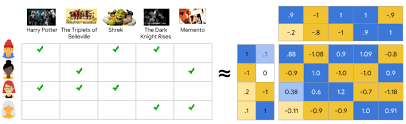

In [43]:
user_nunique, max(user_unique)

(6040, 6041)

In [44]:
# 없는 index 1개를 for문 활용해 찾습니다. 

for i in range(user_nunique): 
    if not np.sort(user_unique)[i] == i+1: # 0은 없음을 확인했기 때문에 pass 
        break
        
print('취급되지 않은 user id는', np.sort(user_unique)[i])

취급되지 않은 user id는 3599


🎬3599로 교환해준 후, row index 0에 대한 케이스도 추가해줘야하나 했는데, row는 compressed가 csr_matrix에서 이뤄지므로 matrix factorization을 거치면 알아서 취급되지 않은 행은 압축되니까 pass해도 되긴 합니다. 하지만 0부터 시작하지 않게 되면 뒤에 MF에서 인덱스가 헷갈리기 때문에 row도 indexing을 해줍니다. 

In [45]:
# 나 자신의 user_id를 비어있는 6041 대신 3599에 할당 => pass
ratings = ratings.replace({'user_id': 6041}, {'user_id':3599})
ratings = ratings.sort_values(['user_id'])

ratings.head()

,user_id,movie_id,view_cnt,movie_idx
0,1,1193,5,0
29,1,745,3,29
30,1,2294,4,30
31,1,3186,4,31
32,1,1566,4,32


In [46]:
# unique함수를 활용해 key, value 값을 바꿔줌으로써 indexing
user_to_idx = {v:k for k,v in enumerate(user_unique)}

print(user_to_idx[3599])
print(np.where(user_unique == 3599))
print(user_unique[3597])

3597
(array([3597]),)
3599


In [97]:
# user_to_idx 통해 user_id 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_data = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_data) == len(ratings):
    print('row indexing OK!!')
    ratings['user_idx'] = temp_data
else:
    print('row indexing Fail!!')
    
ratings.tail(344400)

row indexing OK!!


,user_id,movie_id,view_cnt,movie_idx,user_idx,title,genre
492083,3599,2427,3,238,3597,"thin red line, the",Action|Drama|War
492084,3599,3107,4,376,3597,backdraft,Action|Drama
492085,3599,648,4,58,3597,mission: impossible,Action|Adventure|Mystery
492086,3599,368,4,79,3597,maverick,Action|Comedy|Western
492087,3599,1912,3,242,3597,out of sight,Action|Crime|Romance
...,...,...,...,...,...,...,...
836478,6040,1278,4,540,6038,young frankenstein,Comedy|Horror
836479,6040,2858,4,99,6038,american beauty,Comedy|Drama
836480,6040,58,5,400,6038,"postino, il",Drama|Romance
836481,6040,1947,4,354,6038,west side story,Musical|Romance


In [48]:
# user_idx 기준으로 고유값 다시 계산
user_idx_unique = ratings['user_idx'].unique()
user_idx_nunique = ratings['user_idx'].nunique()

print(user_nunique, ' -> user idx 고유 개수는', user_idx_nunique)
print(max(user_unique),' -> user idx 고유값 행렬의 최대값은', max(user_idx_unique)) 
print(min(user_unique),' -> user idx 고유값 행렬의 최소값은', min(user_idx_unique)) # index 0 포함됨

6040  -> user idx 고유 개수는 6039
6041  -> user idx 고유값 행렬의 최대값은 6038
1  -> user idx 고유값 행렬의 최소값은 0


In [49]:
# merge를 통해 ratings를 보고 참고하기 편하게 변경해줍니다. 
ratings = pd.merge(ratings, movies, on = 'movie_id')
ratings = ratings.sort_values(['user_idx'])
ratings.reset_index(drop=True, inplace=True) # drop = True을 해줘야 오름차순 정렬이 됩니다. 
ratings.head()

,user_id,movie_id,view_cnt,movie_idx,user_idx,title,genre
0,1,1193,5,0,0,one flew over the cuckoo's nest,Drama
1,1,2804,5,7,0,"christmas story, a",Comedy|Drama
2,1,1246,4,52,0,dead poets society,Drama
3,1,2918,4,13,0,ferris bueller's day off,Comedy
4,1,3186,4,31,0,"girl, interrupted",Drama


### CSR Matrix 생성
* shape: row는 user_id가 0이 없는 경우니까 shape은 개수 그대로 가면 된다. col도 동일하게 unique한 개수로 가면 된다. <br>
만약 위와 같은 indexing을 안해주고 진행한다면 unique 개수가 아니라, max(unique 원소들) + 1을 해준 값을 shape 인자로 넣어야합니다. 안 그럼 exceed error가 발생합니다. 

In [50]:
csr_data = csr_matrix((ratings.view_cnt, (ratings.user_idx, ratings.movie_idx)), shape= (user_idx_nunique, movie_idx_nunique))
csr_data

<6039x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836481 stored elements in Compressed Sparse Row format>

## als_model = AlternatingLeastSquares 모델 구성 및 훈련

In [51]:
# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

🎬ALS class에서 __init__의 파라미터
1. factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지 
2. regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지 
3. use_gpu : GPU를 사용할 것인지 
4. iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지 <br>

🎬주의사항! 1, 4번은 늘릴수록 학습이 잘 되지만, 과적합 될 수 있기 때문에 유의해야합니다.

🎬Warning: GPU training requires factor size to be a multiple of 32. Increasing factors from 100 to 128. <br>
factors 100 -> 128

In [52]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=128, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32) # gpu 있으니까 사용?

In [53]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6039 sparse matrix of type '<class 'numpy.int64'>'
	with 836481 stored elements in Compressed Sparse Column format>

🎬ValueError: No CUDA extension has been built, can't train on GPU. <br>
?!.. implicit 패키지는 또 다른가.. 흠.. use_gpu = False로 다시 바꿔줬습니다. <br>
🎬ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html <br>
?!.. 해당 url에서 base 환경과 가상환경에 설치하라는 패키지를 각각 설치해줬습니다. <br>
```
(aiffel) aiffel-dj19@aiffelIddj19:~$ conda install -n base -c conda-forge jupyterlab_widgets
(aiffel) aiffel-dj19@aiffelIddj19:~$ conda install -n aiffel ipywidgets 
```
해당 패키지를 설치해줘도 모델 훈련에서  0%|          | 0/15 [00:00<?, ?it/s] 진행도가 0이 되어서 jupyterlab말고 notebook환경에서 재시도했습니다.

In [54]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

## 영화 선호도 예측 및 영화 추천

In [55]:
ratings.head()

,user_id,movie_id,view_cnt,movie_idx,user_idx,title,genre
0,1,1193,5,0,0,one flew over the cuckoo's nest,Drama
1,1,2804,5,7,0,"christmas story, a",Comedy|Drama
2,1,1246,4,52,0,dead poets society,Drama
3,1,2918,4,13,0,ferris bueller's day off,Comedy
4,1,3186,4,31,0,"girl, interrupted",Drama


In [56]:
type(ratings[ratings['title'] == 'girl, interrupted']['movie_idx'].values[0])

numpy.int64

In [57]:
ratings[ratings['movie_idx'] == 3]['title'].values[0]

'erin brockovich'

In [58]:
def movie_name_to_idx(name : str):
    name_to_idx = ratings[ratings['title'] == name]['movie_idx'].values[0] # id 값만 추출해서 idx
    return name_to_idx

def movie_idx_to_name(movie_id : int):
    idx_to_name = ratings[ratings['movie_idx'] == movie_id]['title'].values[0] # id 값만 추출해서 idx
    return idx_to_name

print(movie_name_to_idx('toy story'))
print(movie_idx_to_name(0))

40
one flew over the cuckoo's nest


### 5가지 영화 중 하나와 그 외의 영화 선호도 예측

In [59]:
my_favorite

,movie_id,title,genre
257,260,star wars: episode iv - a new hope,Action|Adventure|Fantasy|Sci-Fi
1178,1196,star wars: episode v - the empire strikes back,Action|Adventure|Drama|Sci-Fi|War
1192,1210,star wars: episode vi - return of the jedi,Action|Adventure|Romance|Sci-Fi|War
1959,2028,saving private ryan,Action|Drama|War
2789,2858,american beauty,Comedy|Drama


In [60]:
movie_name_to_idx('star wars: episode iv - a new hope')

44

In [98]:
my_idx, starwars = 3597, movie_to_idx[movie_name_to_idx('star wars: episode iv - a new hope')]
my_vector, starwars_vector = als_model.user_factors[my_idx], als_model.item_factors[starwars] # row는 indexing 안해줬으므로 -1

In [99]:
my_vector

array([ 0.6965421 ,  1.7584745 , -2.4600263 , -3.21855   , -0.46394333,
       -0.18172823,  0.9057445 , -3.2700818 , -0.02594549,  1.0706692 ,
       -3.6375546 ,  4.2464476 ,  2.2891824 ,  1.8376935 ,  0.16065769,
        1.7879835 , -0.23368217, -0.26918855,  1.2581598 ,  0.80400914,
       -1.2500333 , -0.38530296, -3.156122  ,  0.37657252,  0.757703  ,
       -1.5769676 ,  1.3153174 , -1.0045791 ,  0.09818766,  0.5383805 ,
        1.3518733 , -0.14955115, -1.9306413 ,  2.1107476 , -0.53699434,
       -1.0109735 , -4.04071   ,  1.0331134 ,  2.8299525 ,  0.30045053,
       -1.5204136 ,  0.03617223,  2.614917  ,  2.6237776 ,  1.9193888 ,
        2.3298388 , -0.2590547 ,  2.4403024 ,  0.44551775, -1.6875694 ,
       -0.28551716, -0.63234586, -1.2430245 ,  1.4706807 , -1.2544221 ,
        1.0219406 ,  0.9963794 , -0.3820687 ,  1.9322022 , -2.9398503 ,
       -0.7766651 , -0.57052076,  2.2993522 , -3.0959783 ,  1.0725102 ,
        1.5643227 ,  2.295448  , -0.79610467, -0.8899967 ,  0.52

In [100]:
starwars_vector

array([-1.74162025e-03,  8.48736241e-03, -1.30302943e-02,  7.43825175e-03,
       -7.27458828e-05,  1.55270156e-02,  1.07736541e-02, -1.22660315e-02,
        9.94177815e-03,  1.75280496e-02,  8.68471165e-04,  2.39840499e-03,
       -1.46859465e-02,  1.50098605e-02,  1.09171784e-02, -4.04178677e-03,
       -5.29477233e-03, -5.59441163e-04,  4.42528538e-03,  1.52699715e-02,
        5.67859737e-04,  8.31754878e-04,  5.69743011e-03,  1.17674088e-02,
        1.01217292e-02, -1.87151285e-03,  1.98289901e-02,  8.40868056e-03,
        1.82235595e-02,  8.17484409e-03,  3.53347394e-03,  5.83697762e-03,
       -1.32233521e-03, -1.52268365e-03,  4.78920201e-03,  3.54602165e-03,
       -3.91678605e-03, -2.00284226e-03, -3.97396646e-03,  1.54903876e-02,
        9.82015207e-03,  2.03796756e-02,  5.65366494e-03,  1.23594329e-02,
        5.31199155e-03,  1.79313892e-03,  1.08861343e-04,  1.10140229e-02,
        1.36678284e-02, -4.31200303e-03,  1.21185929e-02, -4.40912787e-03,
       -8.46474152e-03, -

🎬 내 아이디는 3597이고, 해당하는 사용자 벡터를 구했을때 starwars처럼 내가 선호하는 영화에 포함되는 경우에는 0.55에 가깝게 내적 결과를 보입니다. 이러한 결과를 봤을때 0.5 이상이면 어느 정도 user의 선호도를 맞출 수 있다고 생각해볼 수 있습니다.

In [101]:
# 사용자 특성 벡터와 영화 특성 벡터를 내적하는 코드
np.dot(my_vector, starwars_vector)

0.5552733

🎬특정 영화를 골라 비교해봅시다. meet the parents라는 영화를 확인해봤습니다. 내 선호 영화 리스트는 주로 SF가 많아서 그런지 Comedy 영화인 meet the parents와의 선호도 벡터는 매우 낮게 나왔습니다.

In [103]:
meet_the_parents = movie_to_idx[movie_name_to_idx('meet the parents')]
meet_the_parents_vector = als_model.item_factors[meet_the_parents]
np.dot(my_vector, meet_the_parents_vector)

0.0017858967

In [108]:
ratings[ratings['title'] == 'meet the parents']['genre']

633       Comedy
1012      Comedy
1394      Comedy
2012      Comedy
3529      Comedy
           ...  
814475    Comedy
815279    Comedy
822177    Comedy
823657    Comedy
829832    Comedy
Name: genre, Length: 752, dtype: object

### 내가 좋아하는 영화와 비슷한 영화를 추천

In [109]:
favorite_movie_name = 'star wars: episode iv - a new hope'

In [124]:
favorite_movie = movie_name_to_idx(favorite_movie_name)
similar_movie = als_model.similar_items(favorite_movie, N=15)
similar_movie

[(44, 0.99999994),
 (117, 0.8482047),
 (64, 0.6296733),
 (120, 0.6143012),
 (60, 0.4454651),
 (193, 0.42867833),
 (26, 0.36006013),
 (197, 0.33589488),
 (22, 0.3334875),
 (124, 0.33063707),
 (602, 0.32212636),
 (3600, 0.31415212),
 (200, 0.31188893),
 (91, 0.30724716),
 (5, 0.30612904)]

🎬스타워즈와 비슷한 에일리언, 터미네이터 등과 같은 SF 영화들이 추천된 것을 알 수 있습니다.

In [125]:
# movie_to_idx를 뒤집어, index로부터 movie 이름을 얻는 dict를 생성합니다. 
idx_to_movie_id = {v:k for k,v in movie_to_idx.items()}
similar_movie_name = [movie_idx_to_name(i[0]) for i in similar_movie]
similar_movie_name

['star wars: episode iv - a new hope',
 'star wars: episode v - the empire strikes back',
 'star wars: episode vi - return of the jedi',
 'raiders of the lost ark',
 'star wars: episode i - the phantom menace',
 'alien',
 'e.t. the extra-terrestrial',
 'jaws',
 'back to the future',
 'matrix, the',
 '2001: a space odyssey',
 'match, the',
 'terminator, the',
 'close encounters of the third kind',
 'princess bride, the']

In [126]:
def get_similar_movie(movie_name: str, n: int):
    movie = movie_name_to_idx(movie_name) # name -> idx 
    similar_movie = als_model.similar_items(movie, N = n)
    
    idx_to_movie_id = {v:k for k,v in movie_to_idx.items()}
    similar_movie = [movie_idx_to_name(i[0]) for i in similar_movie]
    return similar_movie

get_similar_movie(favorite_movie_name, 15)

['star wars: episode iv - a new hope',
 'star wars: episode v - the empire strikes back',
 'star wars: episode vi - return of the jedi',
 'raiders of the lost ark',
 'star wars: episode i - the phantom menace',
 'alien',
 'e.t. the extra-terrestrial',
 'jaws',
 'back to the future',
 'matrix, the',
 '2001: a space odyssey',
 'match, the',
 'terminator, the',
 'close encounters of the third kind',
 'princess bride, the']

### 가장 좋아할 만한 영화 추천
🎬filter_already_liked_items 는 유저가 이미 평가한 아이템은 제외하는 Argument입니다.

In [138]:
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(my_idx, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(1102, 0.94047534),
 (816, 0.9249574),
 (971, 0.921725),
 (771, 0.8904816),
 (878, 0.8774788),
 (496, 0.821235),
 (677, 0.80023754),
 (1105, 0.78045106),
 (1548, 0.7718345),
 (721, 0.7635068),
 (147, 0.7327824),
 (768, 0.7188136),
 (1185, 0.6916336),
 (1119, 0.6833804),
 (714, 0.6733197),
 (4, 0.6535865),
 (1496, 0.6518593),
 (1551, 0.6364459),
 (1488, 0.628904),
 (176, 0.6266302)]

In [139]:
movie_recommended = [movie_idx_to_name(i[0]) for i in movie_recommended]
movie_recommended

['deep blue sea',
 'air force one',
 'crow, the',
 'saint, the',
 'strange days',
 'alien�',
 'army of darkness',
 'universal soldier',
 'event horizon',
 'flight of the navigator',
 'under siege',
 'get shorty',
 'sphere',
 'soldier',
 'waterworld',
 "bug's life, a",
 'peacemaker, the',
 'robocop 2',
 'mimic',
 'ghost and the darkness, the']

🎬explain으로 왜 추천해줬는지 확인합니다. 추천한 콘텐츠의 점수에 기여한 다른 콘텐츠와 기여도(합이 콘텐츠의 점수가 됩니다.)를 반환합니다. <br>
alien이나 아까 평가한 데이터가 또 나오는 이유는 implicit의 버그라고 합니다. 그리고 explain 결과를 통해 facult, the라는 영화와 double jeopardy이 가장 크게 기여했습니다. 두 개의 장르를 뽑아보겠습니다. 

In [140]:
recommend_id = movie_name_to_idx('deep blue sea')
explain = als_model.explain(my_idx, csr_data, itemid=recommend_id)
recommend_movie = [(movie_idx_to_name(i[0]), i[1]) for i in explain[1]]
recommend_movie

[('faculty, the', 0.07304219830866768),
 ('double jeopardy', 0.06426417074129381),
 ('arachnophobia', 0.059266642448904214),
 ('payback', 0.05761067058070321),
 ('powder', 0.0493071148396369),
 ('nutty professor, the', 0.04274959667648302),
 ('arrival, the', 0.03819695062322842),
 ('lost world: jurassic park, the', 0.035960163739222034),
 ('thirteenth floor, the', 0.03560614557650328),
 ('as good as it gets', 0.034988245337549385)]

🎬Horror와 Action, Thriller에 해당합니다. 대게 로맨스나 코디미 이런 영화에서는 내적이 낮게 나오고 액션이 있거나 화려한 영화 위주로 추천 점수가 높음을 알 수 있었습니다. 

In [141]:
ratings[(ratings['title'] == 'faculty, the') | (ratings['title'] == 'double jeopardy')]

,user_id,movie_id,view_cnt,movie_idx,user_idx,title,genre
134,2,2881,3,68,1,double jeopardy,Action|Thriller
339,5,2428,3,239,4,"faculty, the",Horror|Sci-Fi
1404,15,2881,3,68,14,double jeopardy,Action|Thriller
2978,26,2881,3,68,25,double jeopardy,Action|Thriller
3279,28,2881,3,68,27,double jeopardy,Action|Thriller
...,...,...,...,...,...,...,...
829647,5995,2881,3,68,5993,double jeopardy,Action|Thriller
831542,6003,2881,4,68,6001,double jeopardy,Action|Thriller
831958,6007,2428,3,239,6005,"faculty, the",Horror|Sci-Fi
833845,6019,2881,4,68,6017,double jeopardy,Action|Thriller


## 회고 
1. 아쉬운 점 
긴.. 여정이었습니다. 시간이 부족해서 멜론 music data를 다뤄보고 싶은 욕심이 있었으나 시도해보지 못해서 아쉬웠습니다. 

2. 이후 도전 
csr matrix를 heatmap으로 보면 전체적인 경향을 파악하기 쉬울거 같다는 생각이 들어 이후에 관련해서는 MF 결과에 대해 히트맵으로 시각화해보는 것을 도전해볼 계획입니다. 

3. 어려웠던 점 
아무래도 csr matrix를 이해하기까지 시간이 좀 걸렸습니다. 그리고 예제에서 나타나는 matrix shape나 indexing 부분이 처음에 이해가 가지않아서 LMS 7조와 열심히 값을 넣어보기도 하고 했는데, 지금은 완벽히 이해를 해서 뿌듯합니다. exceed error를 처음 마주했을 때는 그냥 shape는 굳이 안해줘도 자동적으로 들어가지는 default를 사용하고 넘어갔는데 원소값 기준으로 해서 row와 col이 정해지고, indices와 indptr이 정해지는 개념까지 이해한 후에는 원하는대로의 matrix 크기를 만들 수 있어서 뿌듯했습니다.  

4. 해결사항 및 이슈 
코드에서 순차적으로 서술해둬서 중복이라 생략하겠습니다. 이슈사항으로 크게 인덱싱, csr_matrix가 있었는데, 주로 이론에 대한 잘못된 이해때문에 있어서 노드를 여러번 읽어가면서 해결했습니다. 